<a href="https://colab.research.google.com/github/IcaroTheCreator-ufam/Sports-Injury-Predictions/blob/main/PCA/P%C3%B3s-PCA/P%C3%93S_PCA_XGBOOST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#NFL Injury Analysis



In [ ]:
#Importando as bibliotecas necessárias para processamento de dados, plotagem gráfica e treinamento dos modelos

import numpy as np
import pandas as pd #processamento de dados, para abrir o dataset (arquivo .csv)
import itertools
import seaborn as sns
from sklearn.model_selection import train_test_split
!pip install mglearn

from google.colab import drive #para conectar o google drive ao notebook e trazer os datasets para cá
drive.mount('/content/drive') #diretório onde o drive vai ser instaurado

'''#from google.colab import files''' #função import para justamente fazer o upload dos arquivos do drive
'''uploaded = files.upload()''' #para caso de upload

# para caso de usar imagens
import PIL
from PIL import Image

# para plotagem de gráficos
import matplotlib.pyplot as plt #biblioteca mais comum para plotar as imagens
import seaborn as snsC
import scipy.stats as ss

# bibliotecas e modelos para o treinamento dos modelos
from sklearn.model_selection import StratifiedKFold #função da biblioteca sklearn para dividir os sets de maneira estratificada
from sklearn.model_selection import train_test_split #função da biblioteca sklearn para dividir os sets de maneira padrão
from imblearn.over_sampling import RandomOverSampler, SMOTE #funções para over sampling (aumentar quantidade de ex da classe minoritária (lesão))
import xgboost as xgb #um dos modelos de ML
from sklearn.metrics import accuracy_score, confusion_matrix, cohen_kappa_score #funções que irão avaliar os modelos por meio de scores
from sklearn.metrics import (ConfusionMatrixDisplay, f1_score, classification_report) #mais funções para avaliação do modelo
from sklearn.tree import export_graphviz #função para imprimir a árvore de decisão
import graphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 6.0 MB/s eta 0:00:00
Mounted at /content/drive


# Load Data

In [ ]:
play_df = pd.read_csv('/content/drive/My Drive/Datasets/PlayList.csv')
#player_df = pd.read_csv('/content/drive/My Drive/Datasets/PlayerTrackData.csv')
#este último dataset foi descartado pois ele pesa 3.7 GB e estoura a memória RAM gratuita do Colab e também seus dados não afetam o treinamento de nossos modelos
injury_df = pd.read_csv('/content/drive/My Drive/Datasets/InjuryRecord.csv')

In [ ]:
#Exploração de dados
#Primeiramente gostaria de fazer a limpeza inicial e fazer visualizações para me familiarizar com os dados e gerar ideias para análises posteriores.
#Explorar conjunto de dados

unique_players = play_df.PlayerKey.nunique()
unique_games = play_df.GameID.nunique()
unique_plays = play_df.PlayKey.nunique()

print('There are {} players in the dataset.'.format(unique_players))
print('There are {} games in the dataset.'.format(unique_games))
print('There are {} plays in the dataset.'.format(unique_plays))

There are 250 players in the dataset.
There are 5712 games in the dataset.
There are 267005 plays in the dataset.


In [ ]:
#Game exploration:
# create a dataframe with game-level information
game_df = play_df[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

In [ ]:
def clean_weather(row):
    cloudy = ['Cloudy 50% change of rain', 'Hazy', 'Cloudy.', 'Overcast', 'Mostly Cloudy',
          'Cloudy, fog started developing in 2nd quarter', 'Partly Cloudy',
          'Mostly cloudy', 'Rain Chance 40%',' Partly cloudy', 'Party Cloudy',
          'Rain likely, temps in low 40s', 'Partly Clouidy', 'Cloudy, 50% change of rain','Mostly Coudy', '10% Chance of Rain',
          'Cloudy, chance of rain', '30% Chance of Rain', 'Cloudy, light snow accumulating 1-3"',
          'cloudy', 'Coudy', 'Cloudy with periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy fog started developing in 2nd quarter', 'Cloudy light snow accumulating 1-3"',
         'Cloudywith periods of rain, thunder possible. Winds shifting to WNW, 10-20 mph.',
         'Cloudy 50% change of rain', 'Cloudy and cold',
       'Cloudy and Cool', 'Partly cloudy']

    clear = ['Clear, Windy',' Clear to Cloudy', 'Clear, highs to upper 80s',
             'Clear and clear','Partly sunny',
             'Clear, Windy', 'Clear skies', 'Sunny', 'Partly Sunny', 'Mostly Sunny', 'Clear Skies',
             'Sunny Skies', 'Partly clear', 'Fair', 'Sunny, highs to upper 80s', 'Sun & clouds', 'Mostly sunny','Sunny, Windy',
             'Mostly Sunny Skies', 'Clear and Sunny', 'Clear and sunny','Clear to Partly Cloudy', 'Clear Skies',
            'Clear and cold', 'Clear and warm', 'Clear and Cool', 'Sunny and cold', 'Sunny and warm', 'Sunny and clear']

    rainy = ['Rainy', 'Scattered Showers', 'Showers', 'Cloudy Rain', 'Light Rain', 'Rain shower', 'Rain likely, temps in low 40s.', 'Cloudy, Rain']

    snow = ['Heavy lake effect snow']

    indoor = ['Controlled Climate', 'Indoors', 'N/A Indoor', 'N/A (Indoors)']

    if row.Weather in cloudy:
        return 'Cloudy'

    if row.Weather in indoor:
        return 'Indoor'

    if row.Weather in clear:
        return 'Clear'

    if row.Weather in rainy:
        return 'Rain'

    if row.Weather in snow:
        return 'Snow'

    if row.Weather in ['Cloudy.', 'Heat Index 95', 'Cold']:
        return np.nan

    return row.Weather

def clean_stadiumtype(row):
    if row.StadiumType in ['Bowl', 'Heinz Field', 'Cloudy']:
        return np.nan
    else:
        return row.StadiumType

def clean_play_df(play_df):
    play_df_cleaned = play_df.copy()

    # clean StadiumType
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Oudoor|Outdoors|Ourdoor|Outddors|Outdor|Outside', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Indoors|Indoor, Roof Closed|Indoor, Open Roof', 'Indoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Closed Dome|Domed, closed|Domed, Open|Domed, open|Dome, closed|Domed', 'Dome')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace(r'Retr. Roof-Closed|Outdoor Retr Roof-Open|Retr. Roof - Closed|Retr. Roof-Open|Retr. Roof - Open|Retr. Roof Closed', 'Retractable Roof')
    play_df_cleaned['StadiumType'] = play_df_cleaned['StadiumType'].str.replace('Open', 'Outdoor')
    play_df_cleaned['StadiumType'] = play_df_cleaned.apply(lambda row: clean_stadiumtype(row), axis=1)

    # clean Weather
    play_df_cleaned['Weather'] = play_df_cleaned.apply(lambda row: clean_weather(row), axis=1)

    return play_df_cleaned

In [ ]:
play_df_cleaned = clean_play_df(play_df)
game_df_cleaned = play_df_cleaned[['GameID', 'StadiumType', 'FieldType', 'Weather', 'Temperature']].drop_duplicates().reset_index().drop(columns=['index'])

In [ ]:
#Vejamos rapidamente as lesões:
print('There are {} injury records in total.'.format(len(injury_df)))

There are 105 injury records in total.


In [ ]:
print('{} unique players injured'.format(len(injury_df.PlayerKey.unique())))

100 unique players injured


In [ ]:
#Isso significa que há jogadores lesionados duas vezes!

print('There are {} PlayKey values missing.'.format(len(injury_df) - injury_df.PlayKey.count()))

There are 28 PlayKey values missing.


In [ ]:
# joined cleaned games dataset and injury dataset
game_injury_df = injury_df.set_index('GameID').join(game_df_cleaned.set_index('GameID'), how = 'outer')

# fill null values for the injury columns with zeros
game_injury_df['DM_M1'] = game_injury_df['DM_M1'].fillna(0).astype(int)
game_injury_df['DM_M7'] = game_injury_df['DM_M7'].fillna(0).astype(int)
game_injury_df['DM_M28'] = game_injury_df['DM_M28'].fillna(0).astype(int)
game_injury_df['DM_M42'] = game_injury_df['DM_M42'].fillna(0).astype(int)

game_injury_df.DM_M1 = game_injury_df.DM_M1 - game_injury_df.DM_M7
game_injury_df.DM_M7 = game_injury_df.DM_M7 - game_injury_df.DM_M28
game_injury_df.DM_M28 = game_injury_df.DM_M28 - game_injury_df.DM_M42

# introduce a column with a flag indicating an injury
game_injury_df['Injury'] = game_injury_df['DM_M1'] + game_injury_df['DM_M7'] + game_injury_df['DM_M28'] + game_injury_df['DM_M42']

# drop duplicated surface column
game_injury_df = game_injury_df.drop(columns=['Surface'])

# drop play-level features just for now
game_injury_df = game_injury_df.drop(columns=['PlayerKey', 'PlayKey'])

# create dummy variables
game_injury_df_dummies = pd.get_dummies(game_injury_df, dummy_na = True, drop_first = True).drop(columns=['FieldType_nan'])

In [ ]:
# joined cleaned games dataset and injury dataset
play_injury_df = injury_df.dropna(subset=['PlayKey']).set_index('PlayKey').join(play_df_cleaned.set_index('PlayKey'), how = 'outer', lsuffix='_left', rsuffix='_right')

# fill null values for the injury columns with zeros
play_injury_df['DM_M1'] = play_injury_df['DM_M1'].fillna(0).astype(int)
play_injury_df['DM_M7'] = play_injury_df['DM_M7'].fillna(0).astype(int)
play_injury_df['DM_M28'] = play_injury_df['DM_M28'].fillna(0).astype(int)
play_injury_df['DM_M42'] = play_injury_df['DM_M42'].fillna(0).astype(int)

# introduce a column with a flag indicating an injury
play_injury_df.DM_M1 = play_injury_df.DM_M1 - play_injury_df.DM_M7
play_injury_df.DM_M7 = play_injury_df.DM_M7 - play_injury_df.DM_M28
play_injury_df.DM_M28 = play_injury_df.DM_M28 - play_injury_df.DM_M42

play_injury_df['Injury'] = play_injury_df['DM_M1'] + play_injury_df['DM_M7'] + play_injury_df['DM_M28']+ play_injury_df['DM_M42']

# drop duplicated surface column
play_injury_df = play_injury_df.drop(columns=['Surface'])

# create dummy variables
play_injury_df_dummies = pd.get_dummies(play_injury_df, columns = ['PlayType', 'PositionGroup'], dummy_na = True, drop_first = True)

In [ ]:
features_df = play_injury_df.copy().reset_index()
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])

In [ ]:
# reset index
features_df = play_injury_df.copy().reset_index()
# drop the irrelevant columns
features_df = features_df.drop(columns=['PlayerKey_left','GameID_left','BodyPart', 'PlayKey', 'PlayerKey_right', 'GameID_right', 'DM_M1', 'DM_M7', 'DM_M28', 'DM_M42'])
# convert into dummies
features_df = pd.get_dummies(features_df, dummy_na = False, drop_first = True)

In [ ]:
# split into X and y
y = features_df['Injury']
X = features_df.drop(columns=['Injury'])

In [ ]:
#Importar PCA
from sklearn.decomposition import PCA

#Padronizar os dados
##StandardScaler é uma classe do scikit-learn que fornece uma implementação da padronização dos conjuntos de dados. A padronização é uma técnica importante, especialmente quando se utiliza algoritmos que são sensíveis à escala das variáveis, como é frequentemente o caso em modelos baseados em distância, como o k-Nearest Neighbors (k-NN) ou máquinas de vetores de suporte (SVM).
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #scaler = StandardScaler(): Cria uma instância do StandardScaler. Esta instância será usada para ajustar os parâmetros de padronização (média e desvio padrão) aos dados de treinamento e, em seguida, aplicar a mesma transformação aos dados de teste.

X_padronizado = scaler.fit_transform(X) #X_padronizado = scaler.fit_transform(X_train): Aplica a padronização aos dados (features_df). O método fit_transform ajusta o scaler aos dados de treinamento, calculando a média e o desvio padrão, e, em seguida, aplica a transformação aos dados, resultando em X_padronizado.


In [ ]:
X_padronizado.shape

(267006, 83)

In [ ]:
#Aplicar o PCA

num_componentes = 30  # ajuste conforme necessário
pca = PCA(n_components=num_componentes)
X_pca = pca.fit_transform(X_padronizado)


#X_pca = pca.fit_transform(X_padronizado) #X_pca =
#pca.fit_transform(X_padronizado): Ajusta o modelo PCA aos dados
#padronizados de treinamento (X_padronizado). Durante esse
#processo, o PCA calcula os componentes principais
#(combinações lineares das características originais) que explicam
#a maior parte da variância nos dados.
print("Original shape: {}".format(str(X.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (267006, 83)
Reduced shape: (267006, 30)


In [ ]:
X_pca = pd.DataFrame(X_pca)

In [ ]:
#juntando o dataset de X_pca e y, para formar novamente um dataset só e aí sim o balancear
frames = [X_pca, y]
new_features_df = pd.concat(frames, axis = 1)
new_features_df.reset_index(inplace=True)
new_features_df = new_features_df.drop(columns=['index'])

In [ ]:
#separando o new_features_df em 2 datasets, um com injury igual a 0 e o outro com injury igual a 1_
new_features_df0 = new_features_df[new_features_df['Injury'] < 1]
new_features_df1 = new_features_df[new_features_df['Injury'] >= 1]

In [ ]:
#selecionando aleatoriamente 770 casos de não lesão
new_features_df770 = new_features_df0.sample(n=770)

In [ ]:
#multilplicando o dataframe de lesões por 10
new_features_df2 = pd.DataFrame(np.repeat(new_features_df1.values, 10, axis=0))
new_features_df2.columns = new_features_df1.columns

In [ ]:
#juntando o dataset de injury = 1 com as 770 amostras de treino
new_frames = [new_features_df2, new_features_df770]
post_pca = pd.concat(new_frames)
post_pca.reset_index(inplace=True)
post_pca = post_pca.drop(columns=['index'])

In [ ]:
#separa em features e targets (treino)
post_y = post_pca['Injury']
post_X = post_pca.drop(columns=['Injury'])

In [ ]:
skf = StratifiedKFold(n_splits=2, shuffle = True)
#usa separação estratificada para treinar o conjunto de treino para distribuir igualmente os rótulos em todas as classes
for train_index, test_index in skf.split(post_X, post_y):
    X_train, X_teste = post_X.values[train_index, :], post_X.values[test_index, :]
    y_train, y_teste = post_y[train_index], post_y[test_index]

In [ ]:
'''from sklearn.model_selection import train_test_split

# Dividir os dados em conjuntos de treino e teste
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# X_pca: Dados transformados pelo PCA
# labels: Rótulos correspondentes aos dados
# test_size: Proporção dos dados a serem alocados para o conjunto de teste (neste exemplo, 20%)
# random_state: Semente para garantir reprodutibilidade, escolha um valor fixo ou None
#y_pred = model.predict(X_test_pca)'''


'from sklearn.model_selection import train_test_split\n\n# Dividir os dados em conjuntos de treino e teste\nX_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)\n\n# X_pca: Dados transformados pelo PCA\n# labels: Rótulos correspondentes aos dados\n# test_size: Proporção dos dados a serem alocados para o conjunto de teste (neste exemplo, 20%)\n# random_state: Semente para garantir reprodutibilidade, escolha um valor fixo ou None\n#y_pred = model.predict(X_test_pca)'

In [ ]:
"""X_train_pca e X_test_pca são os conjuntos de treino e teste após a aplicação do PCA.
y_train e y_test são os rótulos correspondentes aos conjuntos de treino e teste.
XGBClassifier é configurado com alguns parâmetros, como objective para tarefa de classificação binária ('binary:logistic'), max_depth para a profundidade máxima das árvores, learning_rate para a taxa de aprendizado e eval_metric para a métrica de avaliação.
Após criar a instância do XGBClassifier, você usa o método fit para treinar o modelo no conjunto de treino e, em seguida, usa o método predict para fazer previsões no conjunto de teste. Finalmente, você avalia o desempenho do modelo usando uma métrica de avaliação, neste caso, a acurácia."""

"X_train_pca e X_test_pca são os conjuntos de treino e teste após a aplicação do PCA.\ny_train e y_test são os rótulos correspondentes aos conjuntos de treino e teste.\nXGBClassifier é configurado com alguns parâmetros, como objective para tarefa de classificação binária ('binary:logistic'), max_depth para a profundidade máxima das árvores, learning_rate para a taxa de aprendizado e eval_metric para a métrica de avaliação.\nApós criar a instância do XGBClassifier, você usa o método fit para treinar o modelo no conjunto de treino e, em seguida, usa o método predict para fazer previsões no conjunto de teste. Finalmente, você avalia o desempenho do modelo usando uma métrica de avaliação, neste caso, a acurácia."

In [ ]:
model = xgb.XGBClassifier(max_depth=3,
                      learning_rate=0.1,
                      n_estimators=100,
                      objective='binary:logistic',
                      booster='gbtree',
                      tree_method='auto',
                      n_jobs=50,
                      gamma=0,
                      min_child_weight=1,
                      max_delta_step=0,
                      subsample=1,
                      colsample_bytree=1,
                      colsample_bylevel=1,
                      colsample_bynode=1,
                      reg_alpha=0,
                      reg_lambda=1,
                      scale_pos_weight=1,
                      base_score=0.5,
                      random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=0, max_depth=3,
              max_leaves=None, min_child_weight=1, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=50, num_parallel_tree=None, random_state=42, ...)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# Fazer previsões no conjunto de treino e teste

xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train, y_train)

y_train_pred = xgb_classifier.predict(X_train)

accuracy = accuracy_score(y_train, y_train_pred)
conf_matrix = confusion_matrix(y_train, y_train_pred)
cohen_kappa = cohen_kappa_score(y_train, y_train_pred)

print('Train Accuracy: {:.4f}'.format(accuracy))
print('Cohen kappa: {:.3f}'.format(cohen_kappa))
print('Confusion Matrix Conjunto Treino: \n {}'.format(conf_matrix))

Train Accuracy: 1.0000
Cohen kappa: 1.000
Confusion Matrix Conjunto Treino: 
 [[385   0]
 [  0 385]]


In [ ]:

# Fazer previsões no conjunto de treino e teste
xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_teste)

accuracy = accuracy_score(y_teste, y_pred)
conf_matrix = confusion_matrix(y_teste, y_pred)
cohen_kappa = cohen_kappa_score(y_teste, y_pred)

print('Test Accuracy: {:.4f}'.format(accuracy))
print('Cohen kappa: {:.3f}'.format(cohen_kappa))
f1 = f1_score(y_pred, y_teste, average="weighted")
print("F1 Score:", f1)
print('Confusion Matrix do Conjunto Teste: \n {}'.format(conf_matrix))

Test Accuracy: 0.9506
Cohen kappa: 0.901
F1 Score: 0.9507698369368552
Confusion Matrix do Conjunto Teste: 
 [[347  38]
 [  0 385]]


[[347  38]
 [  0 385]]


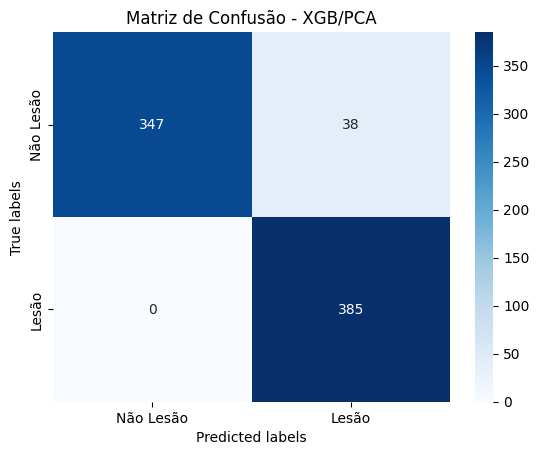

In [ ]:
xgb_classifier.fit(X_train, y_train)
y_pred = xgb_classifier.predict(X_teste)

from sklearn.metrics import confusion_matrix

labels = ["(Não Lesão)", "(Lesão)"]
cf_matrix = confusion_matrix(y_teste, y_pred)
print(cf_matrix)

import seaborn as sns
ax= plt.subplot()
sns.heatmap(cf_matrix, annot=True, fmt='g', ax=ax, cmap = 'Blues')

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Matriz de Confusão - XGB/PCA');
ax.xaxis.set_ticklabels(['Não Lesão', 'Lesão']); ax.yaxis.set_ticklabels(['Não Lesão', 'Lesão']);